# 01 - Classificação com Validação Cruzada Estratificada

Este notebook realiza o pré-processamento, separação de atributos/rótulos e avaliação de três algoritmos supervisionados:
- Árvore de Decisão (Random Forest)
- K-NN (K-Nearest Neighbors)
- MLP (Multi-Layer Perceptron)

A avaliação utiliza F1-score e matriz de confusão via validação cruzada estratificada k-fold, com `random_state` fixo para reprodutibilidade.


In [1]:
# Configurações gerais
RANDOM_STATE = 42
N_JOBS = -1
N_SPLITS = 5  # k-fold
TEST_SIZE = 0.2

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_val_score,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import (
    f1_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    make_scorer,
    classification_report,
    accuracy_score,
    log_loss
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA
import warnings



In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

## Carregamento de dados


## Pré-processamento

### Montando o dataframe

- Carrega um arquivo JSON contendo frames de vídeo com keypoints (pontos-chave) de movimentos
- Normaliza as coordenadas usando o keypoint 0 do primeiro frame como referência
- Filtra apenas os keypoints de ID 11 a 22 (Deixa somente membros superiores, braços, mãos etc.)
    - A visibilidade a partir do keypoint 25 (dos Joelhos para baixo) é muito baixa e também não é tão importante na língua de sinais.
- Calcula estatísticas (média, desvio padrão, mínimo, máximo) para cada keypoint
- Retorna um dicionário com todas as métricas calculadas para cada keypoint
- Não considera o eixo z, pois não se provou muito efetivo em testes

In [4]:
sinais = pd.read_csv('../data/Sinais/sinais.csv')
print(sinais.shape)
print(sinais.head())

def extrair_metricas_do_arquivo(caminho_arquivo):
    """
    Extrai métricas estatísticas dos keypoints de um arquivo JSON de movimentos.
    
    Esta função processa um arquivo JSON contendo frames de vídeo com keypoints,
    normaliza as coordenadas usando o keypoint 0 do primeiro frame como referência,
    filtra apenas os keypoints de ID 11 a 22 (membros superiores) e calcula
    estatísticas para cada keypoint.
    
    Args:
        caminho_arquivo (str): Caminho para o arquivo JSON a ser processado
        
    Returns:
        dict: Dicionário contendo todas as métricas calculadas para cada keypoint
              (média, desvio padrão, mínimo e máximo para x, y e visibilidade)
              
    Raises:
        ValueError: Se o frame 0 não contiver o keypoint com ID 0
    """
    # Carregando o arquivo JSON
    sinal = pd.read_json(caminho_arquivo)
    frames = sinal['frames']
    dados_keypoints = []

    # --- Normalização: pega keypoint id=0 do frame 0 como referência ---
    ref_x, ref_y = None, None
    for keypoint in frames[0]['keypoints']:
        if keypoint['id'] == 0:
            ref_x, ref_y = keypoint['x'], keypoint['y']
            break

    if ref_x is None:
        raise ValueError("Frame 0 não contém keypoint id=0!")

    # Iterando por todos os frames
    for frame_idx, frame_data in enumerate(frames):
        for keypoint in frame_data['keypoints']:
            if 11 <= keypoint['id'] <= 22:
                dados_keypoints.append({
                    'frame': frame_idx,
                    'id': keypoint['id'],
                    # Centralização: subtrai o ponto de referência
                    'x': keypoint['x'] - ref_x,
                    'y': keypoint['y'] - ref_y,
                    'visibility': keypoint['visibility']
                })

    # Convertendo para DataFrame
    df_keypoints = pd.DataFrame(dados_keypoints)

    # Calculando métricas para cada ID e cada atributo
    metricas = df_keypoints.groupby('id').agg({
        'x': ['mean', 'std', 'min', 'max'],
        'y': ['mean', 'std', 'min', 'max'],
        'visibility': ['mean', 'std', 'min', 'max']
    })

    # Achatando colunas
    metricas.columns = ['_'.join(col).strip() for col in metricas.columns.values]
    metricas = metricas.reset_index()

    # Criando dicionário com todas as métricas
    metricas_dict = {}
    for _, row in metricas.iterrows():
        id_keypoint = int(row['id'])
        for col in metricas.columns:
            if col != 'id':
                metricas_dict[f'id_{id_keypoint}_{col}'] = row[col]

    return metricas_dict

(2502, 7)
           file_name  width  height  duration_sec  num_frames   sinal interprete
0  Adição_AP_10.json    738    1008      4.533333         136  Adição    Alexson
1   Adição_AP_1.json    774    1006      4.766667         143  Adição    Alexson
2   Adição_AP_2.json    760    1002      4.433333         133  Adição    Alexson
3   Adição_AP_3.json    762    1000      4.933333         148  Adição    Alexson
4   Adição_AP_4.json    764    1004      4.600000         138  Adição    Alexson


In [5]:
def aplicar_data_augmentation(metricas_dict, num_variantes=3, variacao_percentual=0.05):
    """
    Aplica data augmentation gerando variantes com pequenas perturbações apenas nas coordenadas x e y.
    
    Args:
        metricas_dict: Dicionário com as métricas originais
        num_variantes: Número de variantes a serem geradas
        variacao_percentual: Percentual máximo de variação a ser aplicado
        
    Returns:
        Lista de dicionários com as métricas originais e suas variantes
    """
    resultados = [metricas_dict.copy()]  # Inclui o original
    
    for i in range(num_variantes):
        variante = {}
        for chave, valor in metricas_dict.items():
            # Aplicar variação apenas em valores de x e y
            if isinstance(valor, (int, float)) and ('_x_' in chave or '_y_' in chave):
                # Calcula a variação máxima permitida
                variacao_max = abs(valor * variacao_percentual)
                # Gera um valor aleatório dentro do intervalo de variação
                perturbacao = np.random.uniform(-variacao_max, variacao_max)
                variante[chave] = valor + perturbacao
            else:
                variante[chave] = valor
        
        resultados.append(variante)
    
    return resultados

In [6]:
# --- Pipeline de extração de todos os arquivos ---
resultados = pd.DataFrame()

for idx, row in sinais.iterrows():
    caminho_arquivo = f'../data/Sinais/Sinais/{row["file_name"]}'
    try:
        metricas_arquivo = extrair_metricas_do_arquivo(caminho_arquivo)
        
        # Aplica data augmentation
        metricas_aumentadas = aplicar_data_augmentation(metricas_arquivo, num_variantes=3)
        
        for metricas in metricas_aumentadas:
            temp_df = pd.DataFrame([{**row, **metricas}])
            resultados = pd.concat([resultados, temp_df], ignore_index=True)

        if idx % 500 == 0:
            print(f"Processados {idx+1} arquivos de {len(sinais)}")

    except Exception as e:
        print(f"Erro ao processar {row['file_name']}: {e}")

Processados 1 arquivos de 2502
Erro ao processar Adição_MA_1.json: Frame 0 não contém keypoint id=0!
Processados 501 arquivos de 2502


/var/folders/ns/qqkzf_x52rqdpshm0vpl205r0000gn/T/ipykernel_62014/1812049779.py:25: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sinal = pd.read_json(caminho_arquivo)


Erro ao processar nan: Expected object or value
Processados 1001 arquivos de 2502
Processados 1501 arquivos de 2502
Processados 2001 arquivos de 2502
Processados 2501 arquivos de 2502


In [7]:
resultados.head()


,file_name,width,height,duration_sec,num_frames,sinal,interprete,id_11_x_mean,id_11_x_std,id_11_x_min,id_11_x_max,id_11_y_mean,id_11_y_std,id_11_y_min,id_11_y_max,id_11_visibility_mean,id_11_visibility_std,id_11_visibility_min,id_11_visibility_max,id_12_x_mean,id_12_x_std,id_12_x_min,id_12_x_max,id_12_y_mean,id_12_y_std,id_12_y_min,id_12_y_max,id_12_visibility_mean,id_12_visibility_std,id_12_visibility_min,id_12_visibility_max,id_13_x_mean,id_13_x_std,id_13_x_min,id_13_x_max,id_13_y_mean,id_13_y_std,id_13_y_min,id_13_y_max,id_13_visibility_mean,id_13_visibility_std,id_13_visibility_min,id_13_visibility_max,id_14_x_mean,id_14_x_std,id_14_x_min,id_14_x_max,id_14_y_mean,id_14_y_std,id_14_y_min,id_14_y_max,id_14_visibility_mean,id_14_visibility_std,id_14_visibility_min,id_14_visibility_max,id_15_x_mean,id_15_x_std,id_15_x_min,id_15_x_max,id_15_y_mean,id_15_y_std,id_15_y_min,id_15_y_max,id_15_visibility_mean,id_15_visibility_std,id_15_visibility_min,id_15_visibility_max,id_16_x_mean,id_16_x_std,id_16_x_min,id_16_x_max,id_16_y_mean,id_16_y_std,id_16_y_min,id_16_y_max,id_16_visibility_mean,id_16_visibility_std,id_16_visibility_min,id_16_visibility_max,id_17_x_mean,id_17_x_std,id_17_x_min,id_17_x_max,id_17_y_mean,id_17_y_std,id_17_y_min,id_17_y_max,id_17_visibility_mean,id_17_visibility_std,id_17_visibility_min,id_17_visibility_max,id_18_x_mean,id_18_x_std,id_18_x_min,id_18_x_max,id_18_y_mean,id_18_y_std,id_18_y_min,id_18_y_max,id_18_visibility_mean,id_18_visibility_std,id_18_visibility_min,id_18_visibility_max,id_19_x_mean,id_19_x_std,id_19_x_min,id_19_x_max,id_19_y_mean,id_19_y_std,id_19_y_min,id_19_y_max,id_19_visibility_mean,id_19_visibility_std,id_19_visibility_min,id_19_visibility_max,id_20_x_mean,id_20_x_std,id_20_x_min,id_20_x_max,id_20_y_mean,id_20_y_std,id_20_y_min,id_20_y_max,id_20_visibility_mean,id_20_visibility_std,id_20_visibility_min,id_20_visibility_max,id_21_x_mean,id_21_x_std,id_21_x_min,id_21_x_max,id_21_y_mean,id_21_y_std,id_21_y_min,id_21_y_max,id_21_visibility_mean,id_21_visibility_std,id_21_visibility_min,id_21_visibility_max,id_22_x_mean,id_22_x_std,id_22_x_min,id_22_x_max,id_22_y_mean,id_22_y_std,id_22_y_min,id_22_y_max,id_22_visibility_mean,id_22_visibility_std,id_22_visibility_min,id_22_visibility_max
0,Adição_AP_10.json,738,1008,4.533333,136,Adição,Alexson,183.845588,2.511835,180.000000,190.000000,198.169118,4.561603,189.000000,203.000000,1.0,0.0,1.0,1.0,-156.220588,5.778237,-163.000000,-138.000000,192.198529,5.374590,180.000000,199.000000,1.0,0.0,1.0,1.0,239.051471,20.950142,199.000000,261.000000,460.316176,5.452423,454.000000,472.000000,1.000000,0.000000,1.00,1.0,-271.669118,65.398387,-369.000000,-213.000000,406.279412,63.158905,298.000000,461.000000,1.0,0.0,1.0,1.0,64.242647,37.984109,7.000000,98.000000,505.735294,137.498134,272.000000,619.000000,0.986985,0.009453,0.97,1.0,-116.463235,64.089163,-226.000000,-57.000000,454.566176,188.854547,165.000000,624.000000,0.982868,0.011149,0.97,1.0,16.102941,41.610234,-48.000000,53.000000,539.911765,187.441664,224.000000,689.000000,0.964191,0.021101,0.90,0.99,-66.514706,58.612347,-169.000000,-11.000000,491.823529,227.956100,140.000000,692.000000,0.951029,0.017139,0.92,0.98,4.889706,32.517727,-48.000000,37.000000,508.985294,186.493252,197.000000,658.000000,0.966397,0.019039,0.91,0.99,-39.477941,58.173937,-139.000000,16.000000,465.352941,215.872168,133.000000,656.000000,0.953529,0.014065,0.93,0.98,16.073529,31.556799,-34.000000,46.000000,492.933824,168.908838,211.000000,631.000000,0.965809,0.018720,0.91,0.99,-47.250000,57.658991,-146.000000,9.000000,456.227941,201.162583,149.000000,635.000000,0.950882,0.016621,0.92,0.98
1,Adição_AP_10.json,738,1008,4.533333,136,Adição,Alexson,176.949270,2.440814,186.241140,196.326294,195.662181,4.672858,187.931090,197.630634,1.0,0.0,1.0,1.0,-155.687921,5.608156,-156.244086,-133.946812,194.841553,5.342016,173.114582,190.443868,1.0,0.0,1.0,1.0,247.368360,20.173032,208.197382,253.687485,452.042321,5.507599,433.457812,474.987406,1.000000

In [8]:
resultados.shape

(10000, 151)

# EDA

Análise Exploratória dos Dados (EDA)

- Verificação das dimensões do dataset (10.000 linhas, 151 colunas)
- Análise dos tipos de dados em cada coluna
- Verificação de valores nulos no conjunto de dados
- Cálculo de estatísticas descritivas para colunas numéricas
- Análise da distribuição dos sinais (classes) - balanceamento entre as 25 classes
- Análise da distribuição dos intérpretes - 10 intérpretes com distribuição equilibrada
- Identificação de outliers usando o método IQR (Intervalo Interquartil)
- Preparação dos dados para classificação com codificação das classes

In [9]:
# Análise Exploratória dos Dados

# Verificando as dimensões do dataset
print(f"Dimensões do dataset: {resultados.shape}")

# Verificando os tipos de dados
print("\nTipos de dados:")
print(resultados.dtypes)

# Verificando valores nulos
print("\nValores nulos por coluna:")
print(resultados.isnull().sum())

# Estatísticas descritivas para colunas numéricas
print("\nEstatísticas descritivas para colunas numéricas:")
print(resultados.describe())

# Verificando a distribuição dos sinais (classes)
print("\nDistribuição dos sinais (classes):")
print(resultados['sinal'].value_counts())

# Verificando a distribuição dos intérpretes
print("\nDistribuição dos intérpretes:")
print(resultados['interprete'].value_counts())

# Identificando possíveis outliers em colunas numéricas
print("\nIdentificando outliers em algumas colunas numéricas:")
colunas_numericas = resultados.select_dtypes(include=['int64', 'float64']).columns 

for coluna in colunas_numericas:
    Q1 = resultados[coluna].quantile(0.25)
    Q3 = resultados[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = resultados[(resultados[coluna] < limite_inferior) | (resultados[coluna] > limite_superior)]
    print(f"\nOutliers na coluna {coluna}: {len(outliers)} ({len(outliers)/len(resultados)*100:.2f}%)")

# Criando uma cópia do dataframe para trabalhar com a classificação
df = resultados.copy()

# Criando uma coluna target numérica a partir da coluna 'sinal'
le = LabelEncoder()
df['target'] = le.fit_transform(df['sinal'])

# Mapeamento das classes
print("\nMapeamento das classes (sinal -> target):")
for i, classe in enumerate(le.classes_):
    print(f"{classe} -> {i}")


Dimensões do dataset: (10000, 151)

Tipos de dados:
file_name                 object
width                      int64
height                     int64
duration_sec             float64
num_frames                 int64
                          ...   
id_22_y_max              float64
id_22_visibility_mean    float64
id_22_visibility_std     float64
id_22_visibility_min     float64
id_22_visibility_max     float64
Length: 151, dtype: object

Valores nulos por coluna:
file_name                0
width                    0
height                   0
duration_sec             0
num_frames               0
                        ..
id_22_y_max              0
id_22_visibility_mean    0
id_22_visibility_std     0
id_22_visibility_min     0
id_22_visibility_max     0
Length: 151, dtype: int64

Estatísticas descritivas para colunas numéricas:
              width        height  duration_sec    num_frames  id_11_x_mean   id_11_x_std   id_11_x_min   id_11_x_max  \
count  10000.000000  10000.000000  10

Dimensões do dataset: (10000, 151)

Tipos de dados (contagem):
float64    145
object       3
int64        3
Name: count, dtype: int64


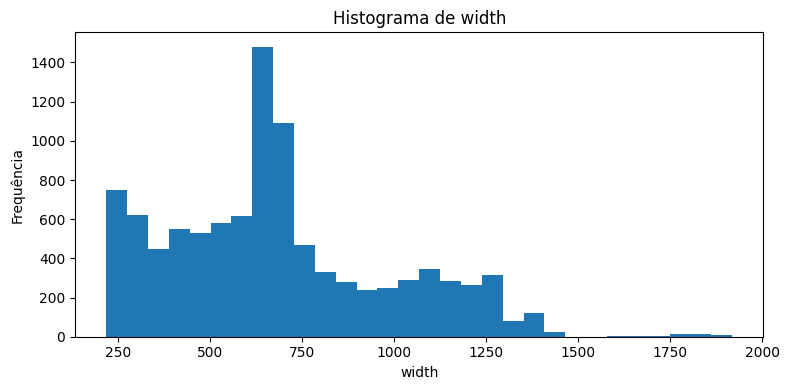

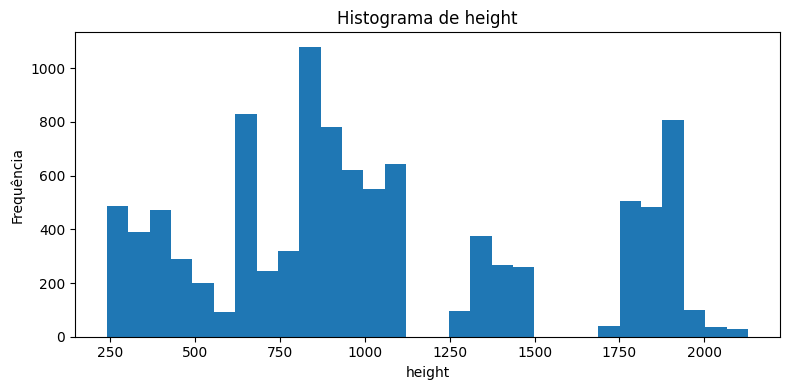

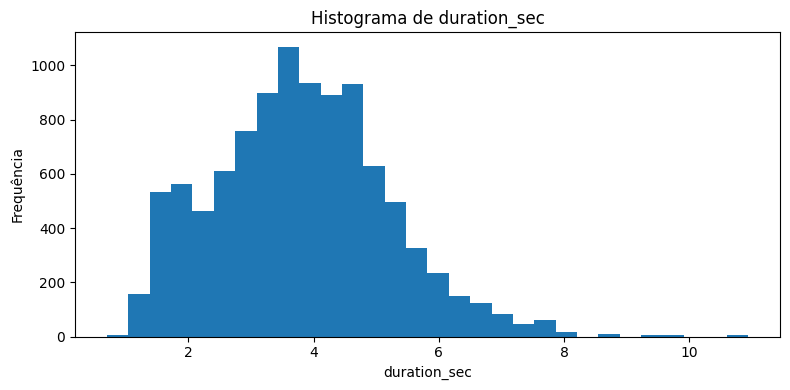

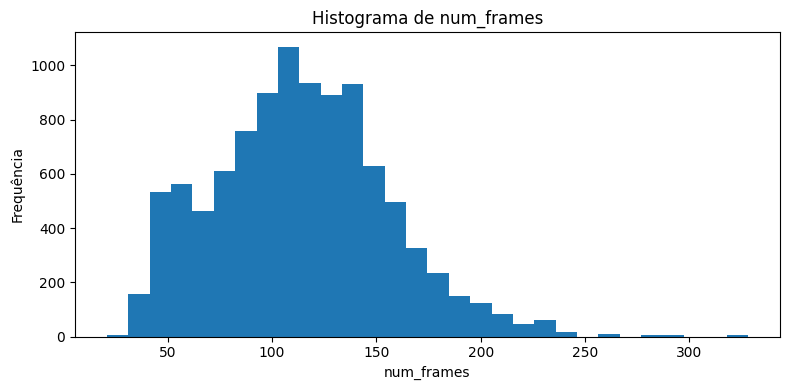

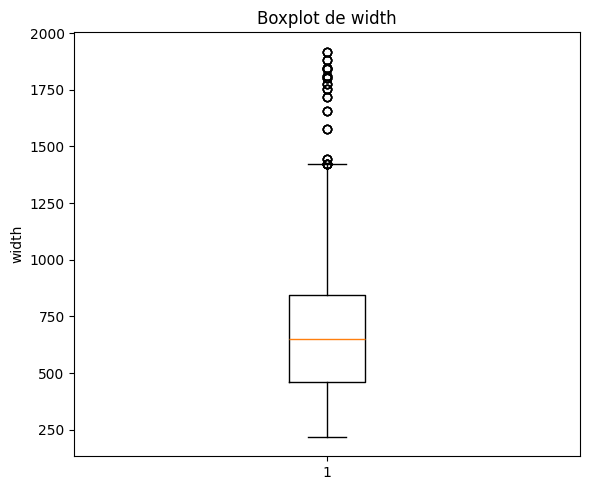

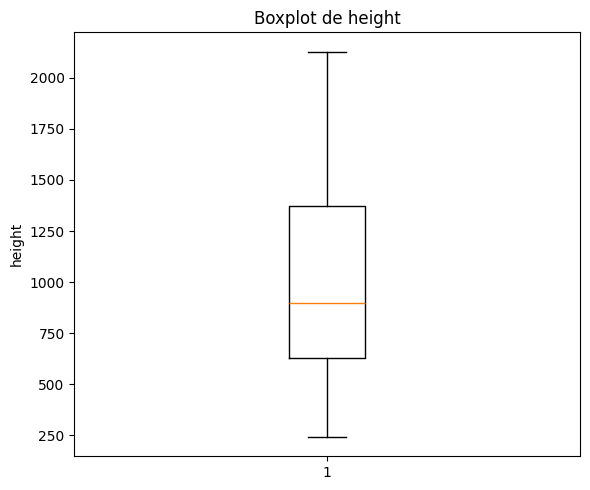

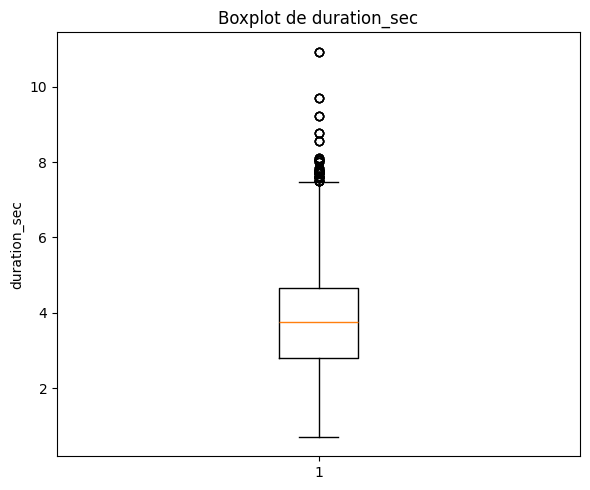

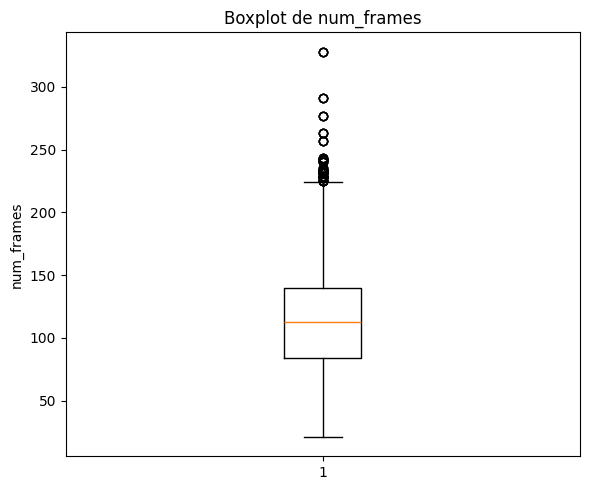

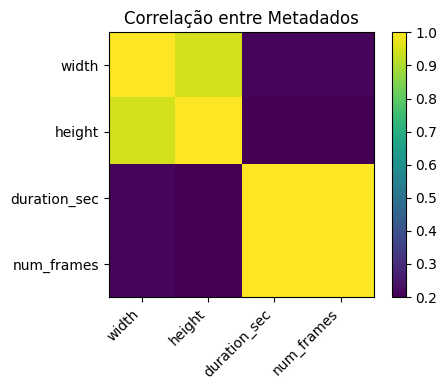

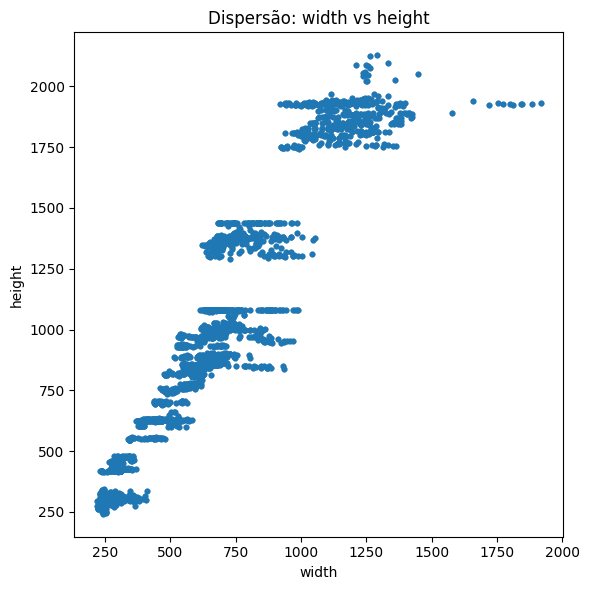

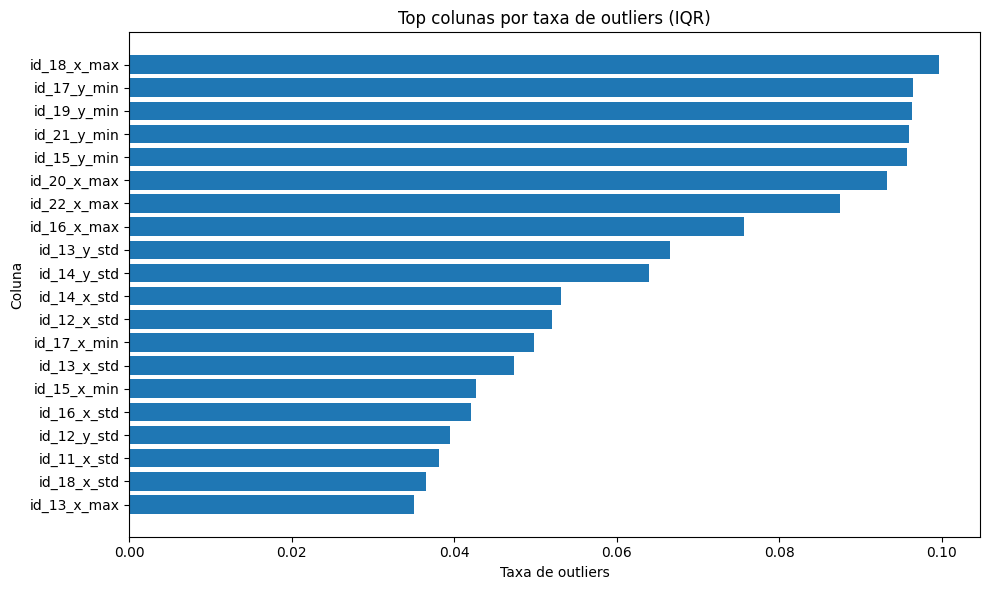


Top colunas por taxa de outliers (IQR):


,coluna,taxa_outlier
63,id_18_x_max,0.0997
58,id_17_y_min,0.0964
74,id_19_y_min,0.0963
90,id_21_y_min,0.0960
42,id_15_y_min,0.0957
79,id_20_x_max,0.0932
95,id_22_x_max,0.0875
47,id_16_x_max,0.0757
25,id_13_y_std,0.0665
33,id_14_y_std,0.0640



Estatísticas descritivas (numéricas):


,count,mean,std,min,25%,50%,75%,max
width,10000.0,683.740000,303.017569,218.000000,461.500000,650.000000,846.000000,1918.000000
height,10000.0,1027.487200,508.098428,242.000000,628.000000,898.000000,1374.500000,2128.000000
duration_sec,10000.0,3.797213,1.379031,0.700000,2.800000,3.766667,4.666667,10.933333
num_frames,10000.0,113.916400,41.370934,21.000000,84.000000,113.000000,140.000000,328.000000
id_11_x_mean,10000.0,158.633783,69.438694,38.240074,98.517801,156.953678,184.362921,317.486348
...,...,...,...,...,...,...,...,...
id_22_x_max,10000.0,-17.213944,94.154305,-383.251745,-60.151259,-8.000000,26.899347,280.893353
id_22_y_mean,10000.0,496.866105,282.493828,44.430036,270.783758,454.728249,643.945633,1180.277344
id_22_y_std,10000.0,222.477701,147.181447,0.714758,119.098394,193.565893,301.470691,695.652656
id_22_y_min,10000.0,168.119533,138.386002,-289.341524,72.241786,144.754218,248.000000,629.096902



Contagem por classe (sinal):


,sinal,contagem
0,Aluno,404
1,Adição,400
2,Contexto,400
3,História,400
4,Geografia,400
5,Física,400
6,Filosofia,400
7,Estudar,400
8,Escola,400
9,Ensinar,400



Contagem por intérprete:


,interprete,contagem
0,Alexson,1004
1,Cecilia,1000
2,Dannubia,1000
3,Dilainne,1000
4,Everton,1000
5,Jackeline,1000
6,Luana,1000
7,Rosenice,1000
8,Tiago,1000
9,Aparecida,996


In [10]:
def explorar_resultados(df: pd.DataFrame, *, topk_outliers: int = 20):
    assert isinstance(df, pd.DataFrame), "`df` precisa ser um DataFrame"
    assert {'sinal','interprete'}.issubset(df.columns), "faltam colunas 'sinal' e/ou 'interprete'"

    # --- 0) Info rápida ---
    print(f"Dimensões do dataset: {df.shape}")
    print("\nTipos de dados (contagem):")
    print(df.dtypes.value_counts())


    # Metadados mais usados (se existirem)
    meta_cols = [c for c in ['width','height','duration_sec','num_frames'] if c in df.columns]

    # --- 3) Histogramas dos metadados ---
    for col in meta_cols:
        fig = plt.figure(figsize=(8, 4))
        plt.hist(df[col].dropna(), bins=30)
        plt.title(f"Histograma de {col}")
        plt.xlabel(col); plt.ylabel("Frequência")
        plt.tight_layout(); plt.show()

    # --- 4) Boxplots (inspeção de outliers) ---
    for col in meta_cols:
        fig = plt.figure(figsize=(6, 5))
        plt.boxplot(df[col].dropna(), vert=True, showfliers=True)
        plt.title(f"Boxplot de {col}")
        plt.ylabel(col)
        plt.tight_layout(); plt.show()

    # --- 5) Correlação entre metadados ---
    if len(meta_cols) >= 2:
        corr = df[meta_cols].corr()
        fig = plt.figure(figsize=(5, 4))
        plt.imshow(corr, interpolation='nearest')
        plt.xticks(range(len(meta_cols)), meta_cols, rotation=45, ha='right')
        plt.yticks(range(len(meta_cols)), meta_cols)
        plt.title("Correlação entre Metadados")
        plt.colorbar()
        plt.tight_layout(); plt.show()

    # --- 6) Dispersão width vs height (se existirem) ---
    if all(c in df.columns for c in ['width','height']):
        fig = plt.figure(figsize=(6, 6))
        plt.scatter(df['width'], df['height'], s=10, alpha=0.6)
        plt.title("Dispersão: width vs height")
        plt.xlabel("width"); plt.ylabel("height")
        plt.tight_layout(); plt.show()

    # --- 7) Top colunas por taxa de OUTLIERS (IQR) ---
    num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    # Excluindo colunas de visibilidade
    num_cols = [col for col in num_cols if 'visibility' not in col]
    
    def iqr_outlier_rate(s: pd.Series):
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
        return float(((s < low) | (s > high)).mean())

    rates = []
    for c in num_cols:
        vals = df[c].dropna()
        if len(vals) > 0:
            rates.append((c, iqr_outlier_rate(vals)))

    if rates:
        out_df = (pd.DataFrame(rates, columns=['coluna','taxa_outlier'])
                    .sort_values('taxa_outlier', ascending=False))
        k = min(topk_outliers, len(out_df))
        fig = plt.figure(figsize=(10, 6))
        plt.barh(out_df['coluna'].head(k)[::-1], out_df['taxa_outlier'].head(k)[::-1])
        plt.title("Top colunas por taxa de outliers (IQR)")
        plt.xlabel("Taxa de outliers"); plt.ylabel("Coluna")
        plt.tight_layout(); plt.show()

        # tabela resumida
        print("\nTop colunas por taxa de outliers (IQR):")
        display(out_df.head(k))

    # --- 8) Tabelas úteis ---
    print("\nEstatísticas descritivas (numéricas):")
    display(df[num_cols].describe().T)

    print("\nContagem por classe (sinal):")
    display(df['sinal'].value_counts().rename_axis('sinal').reset_index(name='contagem'))

    print("\nContagem por intérprete:")
    display(df['interprete'].value_counts().rename_axis('interprete').reset_index(name='contagem'))

explorar_resultados(resultados)


# Retirando elementos com baixa visibilidade

In [11]:
# Definindo um limiar para considerar a visibilidade como baixa
limiar_visibilidade = 0.5

# Criando uma lista para armazenar as linhas com visibilidade baixa
linhas_visibilidade_baixa = []

# Identificando todas as colunas relacionadas à visibilidade
colunas_visibilidade = [col for col in resultados.columns if 'visibility' in col]

# Iterando sobre cada linha do DataFrame
for idx, row in resultados.iterrows():
    # Verificando se alguma coluna de visibilidade média está abaixo do limiar
    colunas_visibilidade_media = [col for col in colunas_visibilidade if 'visibility_mean' in col]
    
    # Se alguma coluna de visibilidade média estiver abaixo do limiar, adiciona à lista
    if any(row[col] < limiar_visibilidade for col in colunas_visibilidade_media):
        linhas_visibilidade_baixa.append(idx)

# Exibindo as linhas com visibilidade baixa
print(f"Foram encontradas {len(linhas_visibilidade_baixa)} linhas com visibilidade média abaixo de {limiar_visibilidade}")

# Selecionando apenas as colunas de visibilidade e informações básicas
colunas_para_exibir = ['file_name', 'sinal', 'interprete'] + colunas_visibilidade

# Exibindo todas as linhas com visibilidade baixa, mas apenas as colunas relacionadas à visibilidade
print("\nLinhas com visibilidade baixa (apenas colunas de visibilidade):")

# Verificando quais sinais têm mais problemas de visibilidade
sinais_problematicos = resultados.iloc[linhas_visibilidade_baixa]['sinal'].value_counts()


# Removendo as linhas com visibilidade baixa do DataFrame
resultados = resultados.drop(linhas_visibilidade_baixa)
print(f"\nDataFrame após remover linhas com visibilidade baixa: {resultados.shape}")


Foram encontradas 40 linhas com visibilidade média abaixo de 0.5

Linhas com visibilidade baixa (apenas colunas de visibilidade):

DataFrame após remover linhas com visibilidade baixa: (9960, 151)


# Remoção de colunas

Vou remover as colunas que nao vão ajudar na classificação

In [12]:
# Identificando todas as colunas relacionadas à visibilidade
colunas_visibilidade = [col for col in resultados.columns if 'visibility' in col]

# Exibindo as colunas que serão removidas
print(f"Removendo {len(colunas_visibilidade)} colunas relacionadas à visibilidade:")
print(colunas_visibilidade)

# Removendo as colunas de visibilidade do DataFrame
resultados = resultados.drop(columns=colunas_visibilidade)
print(f"\nDimensões do DataFrame após remover colunas de visibilidade: {resultados.shape}")

# Removendo colunas que não são relevantes para a classificação
colunas_para_remover = ['file_name', 'duration_sec', 'num_frames', 'width', 'height']
resultados = resultados.drop(columns=colunas_para_remover)
print(f"Dimensões do DataFrame após remover colunas irrelevantes: {resultados.shape}")


Removendo 48 colunas relacionadas à visibilidade:
['id_11_visibility_mean', 'id_11_visibility_std', 'id_11_visibility_min', 'id_11_visibility_max', 'id_12_visibility_mean', 'id_12_visibility_std', 'id_12_visibility_min', 'id_12_visibility_max', 'id_13_visibility_mean', 'id_13_visibility_std', 'id_13_visibility_min', 'id_13_visibility_max', 'id_14_visibility_mean', 'id_14_visibility_std', 'id_14_visibility_min', 'id_14_visibility_max', 'id_15_visibility_mean', 'id_15_visibility_std', 'id_15_visibility_min', 'id_15_visibility_max', 'id_16_visibility_mean', 'id_16_visibility_std', 'id_16_visibility_min', 'id_16_visibility_max', 'id_17_visibility_mean', 'id_17_visibility_std', 'id_17_visibility_min', 'id_17_visibility_max', 'id_18_visibility_mean', 'id_18_visibility_std', 'id_18_visibility_min', 'id_18_visibility_max', 'id_19_visibility_mean', 'id_19_visibility_std', 'id_19_visibility_min', 'id_19_visibility_max', 'id_20_visibility_mean', 'id_20_visibility_std', 'id_20_visibility_min', 'id

In [13]:
resultados.head()

,sinal,interprete,id_11_x_mean,id_11_x_std,id_11_x_min,id_11_x_max,id_11_y_mean,id_11_y_std,id_11_y_min,id_11_y_max,id_12_x_mean,id_12_x_std,id_12_x_min,id_12_x_max,id_12_y_mean,id_12_y_std,id_12_y_min,id_12_y_max,id_13_x_mean,id_13_x_std,id_13_x_min,id_13_x_max,id_13_y_mean,id_13_y_std,id_13_y_min,id_13_y_max,id_14_x_mean,id_14_x_std,id_14_x_min,id_14_x_max,id_14_y_mean,id_14_y_std,id_14_y_min,id_14_y_max,id_15_x_mean,id_15_x_std,id_15_x_min,id_15_x_max,id_15_y_mean,id_15_y_std,id_15_y_min,id_15_y_max,id_16_x_mean,id_16_x_std,id_16_x_min,id_16_x_max,id_16_y_mean,id_16_y_std,id_16_y_min,id_16_y_max,id_17_x_mean,id_17_x_std,id_17_x_min,id_17_x_max,id_17_y_mean,id_17_y_std,id_17_y_min,id_17_y_max,id_18_x_mean,id_18_x_std,id_18_x_min,id_18_x_max,id_18_y_mean,id_18_y_std,id_18_y_min,id_18_y_max,id_19_x_mean,id_19_x_std,id_19_x_min,id_19_x_max,id_19_y_mean,id_19_y_std,id_19_y_min,id_19_y_max,id_20_x_mean,id_20_x_std,id_20_x_min,id_20_x_max,id_20_y_mean,id_20_y_std,id_20_y_min,id_20_y_max,id_21_x_mean,id_21_x_std,id_21_x_min,id_21_x_max,id_21_y_mean,id_21_y_std,id_21_y_min,id_21_y_max,id_22_x_mean,id_22_x_std,id_22_x_min,id_22_x_max,id_22_y_mean,id_22_y_std,id_22_y_min,id_22_y_max
0,Adição,Alexson,183.845588,2.511835,180.000000,190.000000,198.169118,4.561603,189.000000,203.000000,-156.220588,5.778237,-163.000000,-138.000000,192.198529,5.374590,180.000000,199.000000,239.051471,20.950142,199.000000,261.000000,460.316176,5.452423,454.000000,472.000000,-271.669118,65.398387,-369.000000,-213.000000,406.279412,63.158905,298.000000,461.000000,64.242647,37.984109,7.000000,98.000000,505.735294,137.498134,272.000000,619.000000,-116.463235,64.089163,-226.000000,-57.000000,454.566176,188.854547,165.000000,624.000000,16.102941,41.610234,-48.000000,53.000000,539.911765,187.441664,224.000000,689.000000,-66.514706,58.612347,-169.000000,-11.000000,491.823529,227.956100,140.000000,692.000000,4.889706,32.517727,-48.000000,37.000000,508.985294,186.493252,197.000000,658.000000,-39.477941,58.173937,-139.000000,16.000000,465.352941,215.872168,133.000000,656.000000,16.073529,31.556799,-34.000000,46.000000,492.933824,168.908838,211.000000,631.000000,-47.250000,57.658991,-146.000000,9.000000,456.227941,201.162583,149.000000,635.000000
1,Adição,Alexson,176.949270,2.440814,186.241140,196.326294,195.662181,4.672858,187.931090,197.630634,-155.687921,5.608156,-156.244086,-133.946812,194.841553,5.342016,173.114582,190.443868,247.368360,20.173032,208.197382,253.687485,452.042321,5.507599,433.457812,474.987406,-276.576702,66.870047,-383.836744,-214.861814,416.203494,62.308376,285.397031,449.297326,65.410814,37.664394,6.796008,94.583794,527.989453,135.315728,271.570653,640.082379,-113.159523,62.938183,-229.739258,-55.520339,436.261869,196.409821,169.610577,602.781565,16.062672,40.138679,-49.549250,54.051194,525.663999,196.807595,218.508490,684.806450,-69.413457,55.876823,-173.038085,-11.476110,502.210961,223.623396,139.645691,702.437910,5.014765,31.030697,-49.864503,36.518163,505.098909,177.315751,198.719251,630.457473,-40.971622,57.169325,-143.401372,15.878914,443.697344,219.463378,136.704914,634.723491,16.402504,31.688890,-35.252020,46.149281,479.963780,172.431781,209.120816,659.507551,-48.683786,55.773641,-141.590148,8.715792,457.433330,208.050156,147.994434,641.543909
2,Adição,Alexson,185.193982,2.517320,185.325088,193.292520,205.478513,4.741739,186.879821,197.818242,-148.563023,5.621965,-159.885076,-136.963173,191.085344,5.408732,183.596953,200.783808,247.601929,20.590329,194.106275,251.837756,437.891438,5.202842,437.453101,452.695559,-262.680213,63.103600,-359.609883,-218.914780,410.412324,63.978537,285.715836,444.665018,61.895732,36.447328,7.341071,97.089058,492.837578,132.468771,276.892128,621.049183,-111.901521,61.323761,-217.984027,-54.557161,445.981413,188.792100,159.566925,633.421991,16.740752,43.658267,-48.308717,55.340232,549.419380,184.648436,225.104646,694.456147,-69.405553,58.420757,-169.278832,-11.333082,495.315642,238.671381,146.753835,703.884310,4

In [15]:
backup_resultados = resultados.copy()

In [16]:
resultados = backup_resultados.copy()

# Separar features e target


In [17]:

# Definindo coluna alvo
TARGET_COL = 'sinal'

# Codificando o target como inteiro e substituindo no DataFrame
label_encoder = LabelEncoder()
resultados[TARGET_COL] = label_encoder.fit_transform(resultados[TARGET_COL])

# Agora sinal já é inteiro no DataFrame
y = resultados[TARGET_COL].copy()

# Features (removendo target e interprete)
feature_cols = [c for c in resultados.columns if c not in [TARGET_COL, 'interprete']]
X = resultados[feature_cols].copy()


# Train e test sets

In [18]:
# Definindo intérpretes que vão para o conjunto de teste
test_interpretes = ['Dannubia', 'Cecilia']

# Criando máscara de teste/treino
mask_test = resultados['interprete'].isin(test_interpretes)

X_train = X[~mask_test].copy()
y_train = y[~mask_test].copy()

X_test = X[mask_test].copy()
y_test = y[mask_test].copy()

print(f"Conjunto de treino: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Conjunto de teste: X_test={X_test.shape}, y_test={y_test.shape}")

# Criando preprocessador para features numéricas
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),  # Usando RobustScaler para normalização baseada em mediana e IQR
    ],
    remainder='drop'
)

# Distribuição das classes
print("\nDistribuição das classes nos conjuntos:")


Conjunto de treino: X_train=(7960, 96), y_train=(7960,)
Conjunto de teste: X_test=(2000, 96), y_test=(2000,)

Distribuição das classes nos conjuntos:


# Implementando Random Forest

### pipeline

In [19]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=40)),  # melhor PCA encontrado
    ("rf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        n_estimators=300,          # melhor número de árvores
        max_depth=20,              # melhor profundidade máxima
        min_samples_split=10       # melhor split mínimo
    ))
])

### Training e  F1 Score

In [20]:
# Grupos correspondem aos intérpretes do conjunto de treino
groups_train = resultados.loc[~mask_test, 'interprete'].values

# Definir StratifiedGroupKFold
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# F1-score macro
f1_macro = make_scorer(f1_score, average="macro")

# Validação cruzada estratificada com grupos (apenas no treino)
scores = cross_val_score(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=f1_macro,
    groups=groups_train,
    n_jobs=-1
)

print("F1 por fold (grouped CV):", scores)
print("Média do F1-score na validação cruzada:", scores.mean())

# Treinar modelo final com todos os dados de treino
pipeline.fit(X_train, y_train)


F1 por fold (grouped CV): [0.082665   0.36351493 0.48743331 0.36912205 0.67202225]
Média do F1-score na validação cruzada: 0.3949515079783604


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=40)),
                ('rf',
                 RandomForestClassifier(max_depth=20, min_samples_split=10,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

### Test Set

In [21]:
# Avaliar no conjunto de teste ('Dannubia', 'Cecilia')
y_pred = pipeline.predict(X_test)
test_score = f1_score(y_test, y_pred, average="macro")
print(f"F1-score no conjunto de teste final (Dannubia e Cecilia): {test_score:.4f}")

F1-score no conjunto de teste final (Dannubia e Cecilia): 0.4958


### Matriz de Confusão

<Figure size 1000x800 with 0 Axes>

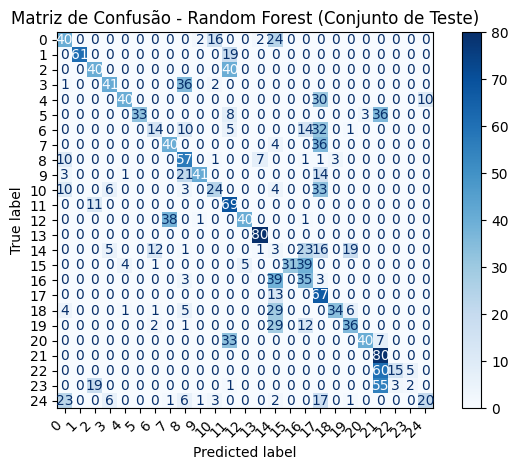

In [22]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Random Forest (Conjunto de Teste)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [23]:
# Exibir relatório de classificação detalhado
print("\nRelatório de Classificação:")
# Usar zero_division=0 para evitar avisos sobre precisão indefinida
print(classification_report(y_test, y_pred, zero_division=0))



Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.44      0.48      0.46        84
           1       1.00      0.76      0.87        80
           2       0.57      0.50      0.53        80
           3       0.71      0.51      0.59        80
           4       0.87      0.50      0.63        80
           5       1.00      0.41      0.58        80
           6       0.47      0.18      0.26        76
           7       0.51      0.50      0.50        80
           8       0.40      0.71      0.51        80
           9       0.91      0.51      0.66        80
          10       0.52      0.30      0.38        80
          11       0.39      0.86      0.54        80
          12       0.89      0.50      0.64        80
          13       0.89      1.00      0.94        80
          14       0.02      0.04      0.03        80
          15       1.00      0.39      0.56        80
          16       0.28      0.44      0.34        8

## KNN


### Pipeline

In [24]:
# Criando o pipeline com preprocessamento e KNN
knn_pipeline = Pipeline([
    ('preprocess', preprocess),
    ("pca", PCA(n_components=40, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan', p=1))
])


### F1 Score

In [25]:

# Validação cruzada para F1-Score usando StratifiedGroupKFold para evitar vazamento de dados
# Isso garante que exemplos do mesmo intérprete não apareçam em diferentes folds
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
groups_train = resultados.loc[~mask_test, 'interprete'].values
f1_scores = cross_val_score(knn_pipeline, X_train, y_train, cv=cv, scoring='f1_macro', groups=groups_train)
print("\nF1-Score com validação cruzada estratificada por grupos (5-fold):")
print(f"Média: {f1_scores.mean():.4f}, Desvio padrão: {f1_scores.std():.4f}")
print(f"Scores individuais: {f1_scores}")



F1-Score com validação cruzada estratificada por grupos (5-fold):
Média: 0.3238, Desvio padrão: 0.1557
Scores individuais: [0.09861801 0.21876621 0.49997229 0.30984854 0.49181087]


### test set

In [26]:
# Treinando o modelo
knn_pipeline.fit(X_train, y_train)

# Fazendo previsões
y_pred = knn_pipeline.predict(X_test)

# Avaliando o modelo
print("Resultados do KNN:")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred, average='macro'):.4f}")


Resultados do KNN:
Acurácia: 0.4010
F1-Score: 0.3971


### Matriz de Confusao

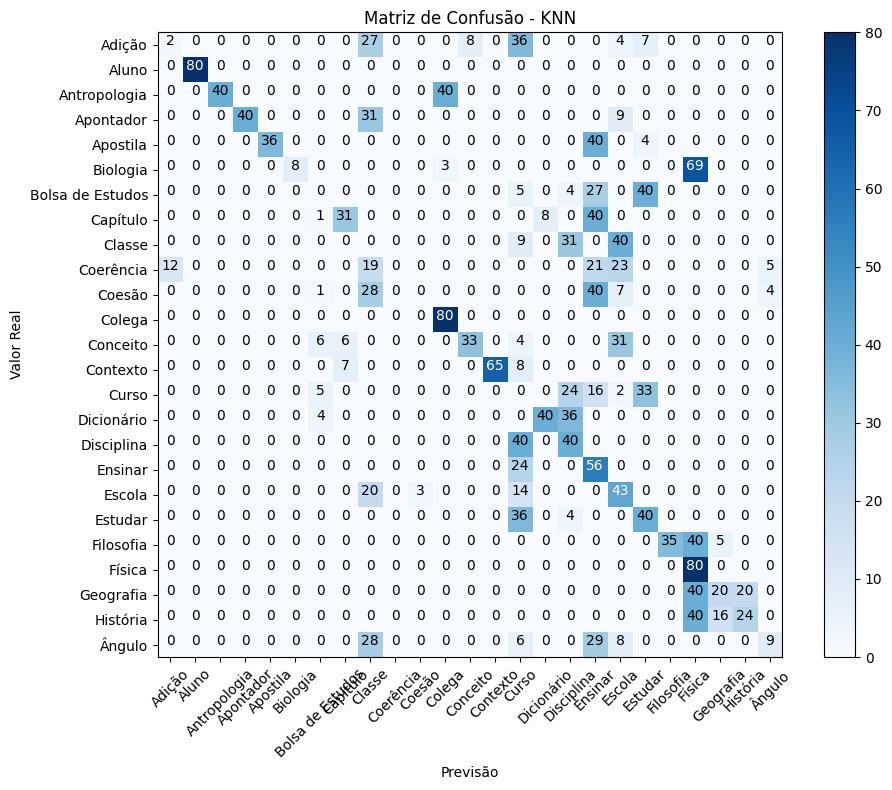

In [27]:

# Matriz de confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - KNN')
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)
plt.xlabel('Previsão')
plt.ylabel('Valor Real')

# Adicionando valores na matriz
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [28]:
print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred, zero_division=0))


Relatório de classificação:
              precision    recall  f1-score   support

           0       0.14      0.02      0.04        84
           1       1.00      1.00      1.00        80
           2       1.00      0.50      0.67        80
           3       1.00      0.50      0.67        80
           4       1.00      0.45      0.62        80
           5       1.00      0.10      0.18        80
           6       0.00      0.00      0.00        76
           7       0.70      0.39      0.50        80
           8       0.00      0.00      0.00        80
           9       0.00      0.00      0.00        80
          10       0.00      0.00      0.00        80
          11       0.65      1.00      0.79        80
          12       0.80      0.41      0.55        80
          13       1.00      0.81      0.90        80
          14       0.00      0.00      0.00        80
          15       0.83      0.50      0.62        80
          16       0.29      0.50      0.37        8

# MLP


### Pipeline

In [29]:
# Criando o pipeline para o MLP
mlp_pipeline = Pipeline([
    ('preprocess', preprocess),
    ("pca", PCA(n_components=40, random_state=42)),  # opcional, compare com None
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(100,),  # Tamanho das camadas ocultas
        activation='relu',          # Função de ativação
        solver='adam',              # Otimizador
        alpha=0.0001,               # Termo de regularização
        batch_size='auto',          # Tamanho do lote
        learning_rate='constant',   # Taxa de aprendizado
        learning_rate_init=0.001,   # Taxa de aprendizado inicial
        max_iter=400,               # Número máximo de iterações
        random_state=RANDOM_STATE,  # Semente aleatória
        verbose=True                # Para obter informações de loss durante o treinamento
    ))
])


### Treinando

Iteration 1, loss = 3.08416271
Iteration 2, loss = 2.38924252
Iteration 3, loss = 1.93160572
Iteration 4, loss = 1.58756286
Iteration 5, loss = 1.32378085
Iteration 6, loss = 1.11368329
Iteration 7, loss = 0.94830721
Iteration 8, loss = 0.81502736
Iteration 9, loss = 0.70741855
Iteration 10, loss = 0.61851751
Iteration 11, loss = 0.54610262
Iteration 12, loss = 0.48383695
Iteration 13, loss = 0.43158564
Iteration 14, loss = 0.38696431
Iteration 15, loss = 0.34896886
Iteration 16, loss = 0.31590144
Iteration 17, loss = 0.28704440
Iteration 18, loss = 0.26110908
Iteration 19, loss = 0.23949616
Iteration 20, loss = 0.22019179
Iteration 21, loss = 0.20208212
Iteration 22, loss = 0.18655043
Iteration 23, loss = 0.17286738
Iteration 24, loss = 0.16030160
Iteration 25, loss = 0.14897442
Iteration 26, loss = 0.13891087
Iteration 27, loss = 0.12941552
Iteration 28, loss = 0.12138221
Iteration 29, loss = 0.11330828
Iteration 30, loss = 0.10681220
Iteration 31, loss = 0.10039071
Iteration 32, los

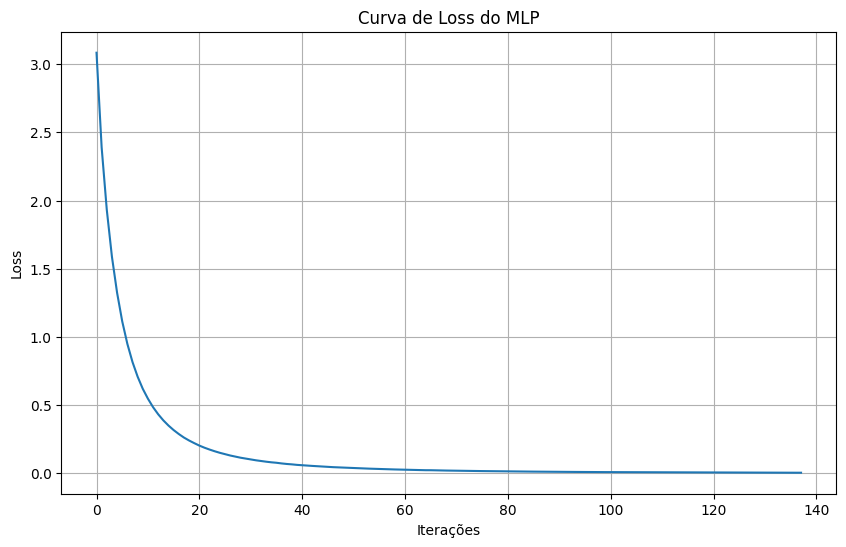

In [30]:

# Treinando o modelo
mlp_pipeline.fit(X_train, y_train)

# Extraindo o histórico de loss
mlp = mlp_pipeline.named_steps['mlp']
loss_values = mlp.loss_curve_

# Plotando a curva de loss
plt.figure(figsize=(10, 6))
plt.plot(loss_values)
plt.title('Curva de Loss do MLP')
plt.xlabel('Iterações')
plt.ylabel('Loss')
plt.grid(True)
plt.show()



### test set

In [31]:
# Fazendo previsões
y_pred = mlp_pipeline.predict(X_test)

# Avaliando o modelo
print("Resultados do MLP:")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred, average='macro'):.4f}")



Resultados do MLP:
Acurácia: 0.4835
F1-Score: 0.4691


In [32]:
print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred, zero_division=0))



Relatório de classificação:
              precision    recall  f1-score   support

           0       0.28      0.83      0.42        84
           1       1.00      1.00      1.00        80
           2       0.83      0.50      0.62        80
           3       0.62      0.80      0.70        80
           4       0.00      0.00      0.00        80
           5       1.00      0.44      0.61        80
           6       0.49      0.42      0.45        76
           7       0.89      0.50      0.64        80
           8       0.76      0.49      0.60        80
           9       0.36      0.57      0.44        80
          10       0.00      0.00      0.00        80
          11       0.88      0.91      0.90        80
          12       0.73      0.46      0.56        80
          13       0.79      1.00      0.88        80
          14       0.14      0.12      0.13        80
          15       0.86      0.30      0.44        80
          16       0.45      0.50      0.48        8

### F1 Score

In [33]:
# Validação cruzada para F1-Score usando StratifiedGroupKFold para evitar vazamento de dados
# Isso garante que exemplos do mesmo intérprete não apareçam em diferentes folds
mask_train = ~mask_test  # Garantindo que estamos usando apenas os dados de treinamento
groups_train = resultados.loc[mask_train, 'interprete'].values

# Verificando os tamanhos para garantir consistência
print(f"\nVerificando tamanhos: X_train={X_train.shape}, y_train={y_train.shape}, groups_train={len(groups_train)}")

# Garantindo que todos os arrays têm o mesmo número de amostras
if len(groups_train) != len(X_train):
    print("AVISO: Inconsistência no número de amostras. Ajustando groups_train para corresponder a X_train.")
    groups_train = groups_train[:len(X_train)]

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = cross_val_score(mlp_pipeline, X_train, y_train, cv=cv, scoring='f1_macro', groups=groups_train)



Verificando tamanhos: X_train=(7960, 96), y_train=(7960,), groups_train=7960
Iteration 1, loss = 3.04482140
Iteration 2, loss = 2.34899991
Iteration 3, loss = 1.88251738
Iteration 4, loss = 1.53517787
Iteration 5, loss = 1.26467755
Iteration 6, loss = 1.05485085
Iteration 7, loss = 0.89124639
Iteration 8, loss = 0.76163222
Iteration 9, loss = 0.65798242
Iteration 10, loss = 0.57823863
Iteration 11, loss = 0.50976540
Iteration 12, loss = 0.45051697
Iteration 13, loss = 0.40084576
Iteration 14, loss = 0.35683493
Iteration 15, loss = 0.32145319
Iteration 16, loss = 0.29231928
Iteration 17, loss = 0.26422779
Iteration 18, loss = 0.24100584
Iteration 19, loss = 0.22078708
Iteration 20, loss = 0.20178446
Iteration 21, loss = 0.19077252
Iteration 22, loss = 0.17219561
Iteration 23, loss = 0.16105799
Iteration 24, loss = 0.14861293
Iteration 25, loss = 0.13794031
Iteration 26, loss = 0.12862954
Iteration 27, loss = 0.12483812
Iteration 28, loss = 0.11341700
Iteration 29, loss = 0.10614838
Ite

In [34]:
print("\nF1-Score com validação cruzada estratificada por grupos (5-fold):")
print(f"Média: {f1_scores.mean():.4f}, Desvio padrão: {f1_scores.std():.4f}")
print(f"Scores individuais: {f1_scores}")


F1-Score com validação cruzada estratificada por grupos (5-fold):
Média: 0.4400, Desvio padrão: 0.2124
Scores individuais: [0.12529144 0.33249363 0.60831451 0.40194879 0.73195001]


### Matriz de confusao

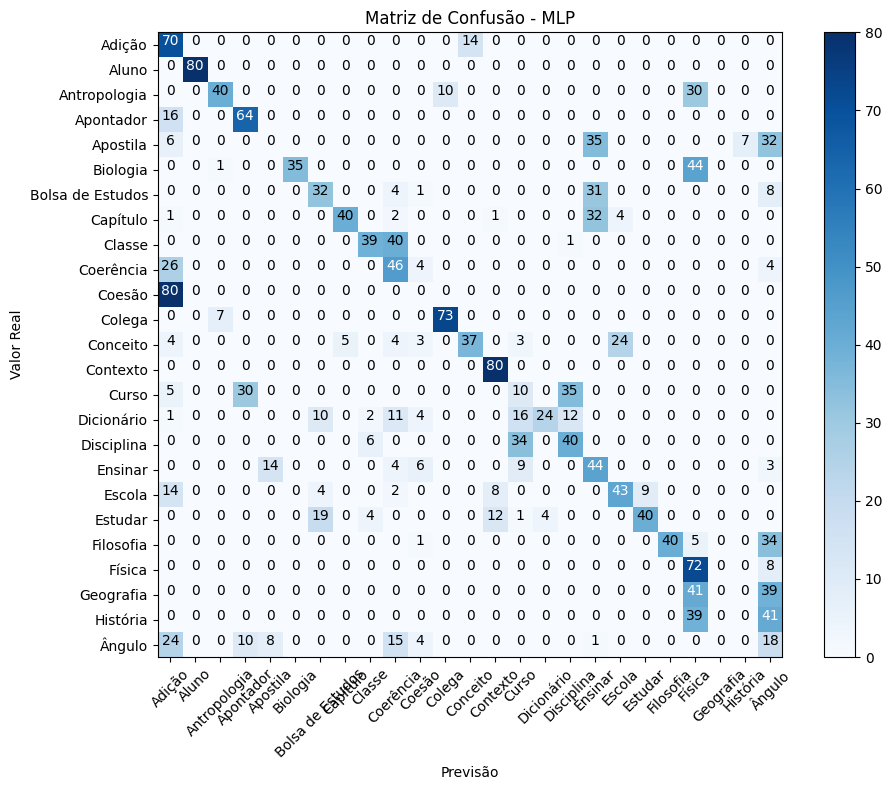

In [35]:
# Matriz de confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - MLP')
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)
plt.xlabel('Previsão')
plt.ylabel('Valor Real')

# Adicionando valores na matriz
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

### Train e test sets  
- Adicionar Validation set para tirar overfit

In [36]:
# Definindo intérpretes que vão para os conjuntos de teste e validação
test_interpretes = ['Dannubia', 'Cecilia']
val_interpretes = ['Jackeline']  # Separando um intérprete para validação

# Criando máscaras para teste, validação e treino
mask_test = resultados['interprete'].isin(test_interpretes)
mask_val = resultados['interprete'].isin(val_interpretes)

# Separando os conjuntos
X_train = X[~(mask_test | mask_val)].copy()
y_train = y[~(mask_test | mask_val)].copy()

X_val = X[mask_val].copy()
y_val = y[mask_val].copy()

X_test = X[mask_test].copy()
y_test = y[mask_test].copy()

print(f"Conjunto de treino: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Conjunto de validação: X_val={X_val.shape}, y_val={y_val.shape}")
print(f"Conjunto de teste: X_test={X_test.shape}, y_test={y_test.shape}")

# Criando preprocessador para features numéricas
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),  # Usando RobustScaler para normalização baseada em mediana e IQR
    ],
    remainder='drop'
)


Conjunto de treino: X_train=(6960, 96), y_train=(6960,)
Conjunto de validação: X_val=(1000, 96), y_val=(1000,)
Conjunto de teste: X_test=(2000, 96), y_test=(2000,)


### Fit preprocess + PCA apenas no TREINO

In [37]:
prep_pca = Pipeline([
    ('preprocess', preprocess),                  # seu RobustScaler em numeric_features
    ('pca', PCA(n_components=40, random_state=42))  # ajuste n_components conforme seus testes
])
X_train_tr = prep_pca.fit_transform(X_train)
X_val_tr   = prep_pca.transform(X_val)
X_test_tr  = prep_pca.transform(X_test)

classes = np.unique(y_train)
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),   
    activation='relu',
    solver='adam',
    alpha=1e-3,                     # L2 mais forte 
    learning_rate='constant',
    learning_rate_init=1e-3,
    batch_size=128,
    max_iter=1,                     # 1 época por chamada
    warm_start=True,                # reutiliza pesos entre chamadas
    shuffle=True,
    random_state=RANDOM_STATE,
    verbose=False                  
)

# Loop de treino com early stopping por *validation loss*
max_epochs   = 500
patience     = 20          # nº de épocas sem melhora antes de parar
min_delta    = 1e-4        # melhoria mínima para considerar "melhorou"
best_val     = np.inf
pat_count    = 0
best_model   = None
train_curve, val_curve = [], []

# Desabilitar warnings durante o treinamento
warnings.filterwarnings("ignore", category=UserWarning)

for epoch in range(1, max_epochs + 1):
    # uma "época"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mlp.fit(X_train_tr, y_train)

    # train loss (última loss interna do MLP)
    train_loss = mlp.loss_curve_[-1] if mlp.loss_curve_ else np.nan
    train_curve.append(train_loss)

    # val loss (log_loss com as probabilidades do modelo)
    proba_val = mlp.predict_proba(X_val_tr)
    val_loss = log_loss(y_val, proba_val, labels=classes)
    val_curve.append(val_loss)

    # early stopping por paciência
    if val_loss + min_delta < best_val:
        best_val = val_loss
        pat_count = 0
        best_model = deepcopy(mlp)   # salva melhor conjunto de pesos
    else:
        pat_count += 1
        if pat_count >= patience:
            print(f"Early stopping na época {epoch} (val loss não melhora há {patience} épocas).")
            break

print(f"Melhor val loss: {best_val:.6f}")


Early stopping na época 25 (val loss não melhora há 20 épocas).
Melhor val loss: 0.888672


### Curva de Loss

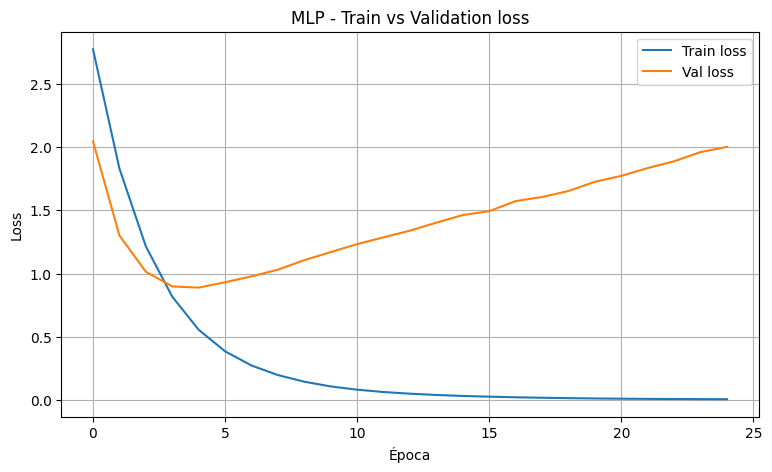

In [38]:

# 4) Plota curvas de perda (train vs validation)
plt.figure(figsize=(9,5))
plt.plot(train_curve, label="Train loss")
plt.plot(val_curve,   label="Val loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("MLP - Train vs Validation loss")
plt.legend()
plt.grid(True)
plt.show()

names = [str(c) for c in label_encoder.classes_]          
labels = np.arange(len(names))                            


### Avaliacao do Validation

In [39]:

y_val_pred = best_model.predict(X_val_tr)
print("\nValidação (intérprete(s) separado(s)):")
print(f"Acurácia: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"F1-macro: {f1_score(y_val, y_val_pred, average='macro'):.4f}")
print(classification_report(y_val, y_val_pred,
                            labels=labels, target_names=names))


Validação (intérprete(s) separado(s)):
Acurácia: 0.7000
F1-macro: 0.6610
                  precision    recall  f1-score   support

          Adição       1.00      0.90      0.95        40
           Aluno       1.00      1.00      1.00        40
    Antropologia       1.00      1.00      1.00        40
       Apontador       1.00      1.00      1.00        40
        Apostila       0.75      1.00      0.86        40
        Biologia       0.98      1.00      0.99        40
Bolsa de Estudos       1.00      0.10      0.18        40
        Capítulo       1.00      1.00      1.00        40
          Classe       0.98      1.00      0.99        40
       Coerência       0.00      0.00      0.00        40
          Coesão       1.00      0.10      0.18        40
          Colega       1.00      1.00      1.00        40
        Conceito       0.29      1.00      0.45        40
        Contexto       1.00      1.00      1.00        40
           Curso       0.00      0.00      0.00        

### Avaliacao do test set

In [40]:
y_test_pred = best_model.predict(X_test_tr)
print("\nTeste (intérpretes fora do treino):")
print(f"Acurácia: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1-macro: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(classification_report(y_test, y_test_pred,
                            labels=labels, target_names=names))


Teste (intérpretes fora do treino):
Acurácia: 0.4015
F1-macro: 0.3985
                  precision    recall  f1-score   support

          Adição       0.17      0.48      0.25        84
           Aluno       1.00      0.90      0.95        80
    Antropologia       0.51      0.50      0.51        80
       Apontador       0.94      0.36      0.52        80
        Apostila       0.00      0.00      0.00        80
        Biologia       1.00      0.30      0.46        80
Bolsa de Estudos       0.00      0.00      0.00        76
        Capítulo       0.91      0.50      0.65        80
          Classe       0.73      0.40      0.52        80
       Coerência       0.00      0.00      0.00        80
          Coesão       0.00      0.00      0.00        80
          Colega       0.67      0.72      0.69        80
        Conceito       0.73      0.45      0.56        80
        Contexto       0.92      1.00      0.96        80
           Curso       0.25      0.35      0.29        80


### Matriz de Confusao

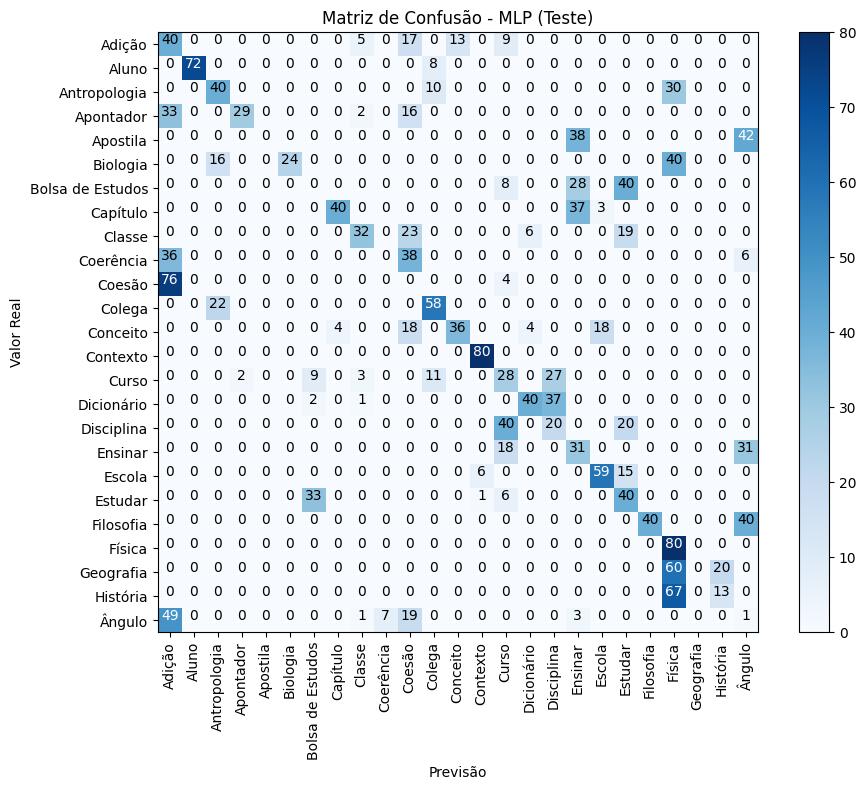

In [44]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - MLP (Teste)')
plt.colorbar()
ticks = np.arange(len(label_encoder.classes_))
plt.xticks(ticks, label_encoder.classes_, rotation=90)
plt.yticks(ticks, label_encoder.classes_)
plt.xlabel('Previsão'); plt.ylabel('Valor Real')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


### F1 validation cruzada estratificada

In [42]:
# Validação cruzada para F1-Score usando StratifiedGroupKFold para evitar vazamento de dados
# Isso garante que exemplos do mesmo intérprete não apareçam em diferentes folds
mask_train = ~mask_test  # Garantindo que estamos usando apenas os dados de treinamento
groups_train = resultados.loc[mask_train, 'interprete'].values

# Verificando os tamanhos para garantir consistência
print(f"\nVerificando tamanhos: X_train={X_train.shape}, y_train={y_train.shape}, groups_train={len(groups_train)}")

# Garantindo que todos os arrays têm o mesmo número de amostras
if len(groups_train) != len(X_train):
    print("AVISO: Inconsistência no número de amostras. Ajustando groups_train para corresponder a X_train.")
    groups_train = groups_train[:len(X_train)]

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Definindo o pipeline para validação cruzada
mlp_cv = MLPClassifier(
    hidden_layer_sizes=(128, 64),   
    activation='relu',
    solver='adam',
    alpha=1e-3,
    learning_rate='constant',
    learning_rate_init=1e-3,
    batch_size=128,
    max_iter=200,
    random_state=RANDOM_STATE
)

mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=40, random_state=42)),
    ('mlp', mlp_cv)
])

# Realizando validação cruzada com F1-Score
f1_scores = cross_val_score(mlp_pipeline, X_train, y_train, cv=cv, scoring='f1_macro', groups=groups_train)
print("\nF1-Score com validação cruzada estratificada por grupos (5-fold):")
print(f"Média: {f1_scores.mean():.4f}, Desvio padrão: {f1_scores.std():.4f}")
print(f"Scores individuais: {f1_scores}")



Verificando tamanhos: X_train=(6960, 96), y_train=(6960,), groups_train=7960
AVISO: Inconsistência no número de amostras. Ajustando groups_train para corresponder a X_train.

F1-Score com validação cruzada estratificada por grupos (5-fold):
Média: 0.3072, Desvio padrão: 0.1190
Scores individuais: [0.28494084 0.33014478 0.30345786 0.1218095  0.49540593]


### Testes Extras



TREINANDO ÁRVORE DE DECISÃO

Resultados da Árvore de Decisão:
Acurácia: 0.2715
F1-Score: 0.2392

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.09      0.14      0.11        84
           1       1.00      0.91      0.95        80
           2       0.01      0.01      0.01        80
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        80
           5       0.20      0.10      0.13        80
           6       0.01      0.01      0.01        76
           7       0.77      0.29      0.42        80
           8       0.50      0.31      0.38        80
           9       0.13      0.04      0.06        80
          10       0.03      0.03      0.03        80
          11       0.59      1.00      0.74        80
          12       0.53      0.26      0.35        80
          13       0.93      0.65      0.76        80
          14       0.00      0.00      0.00        80
        

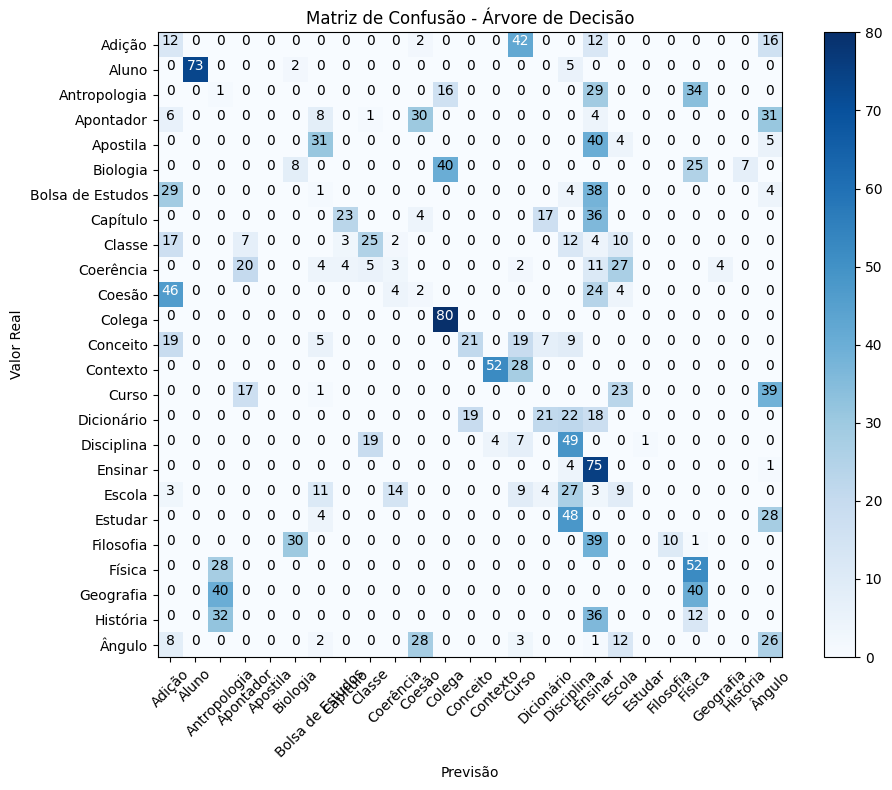

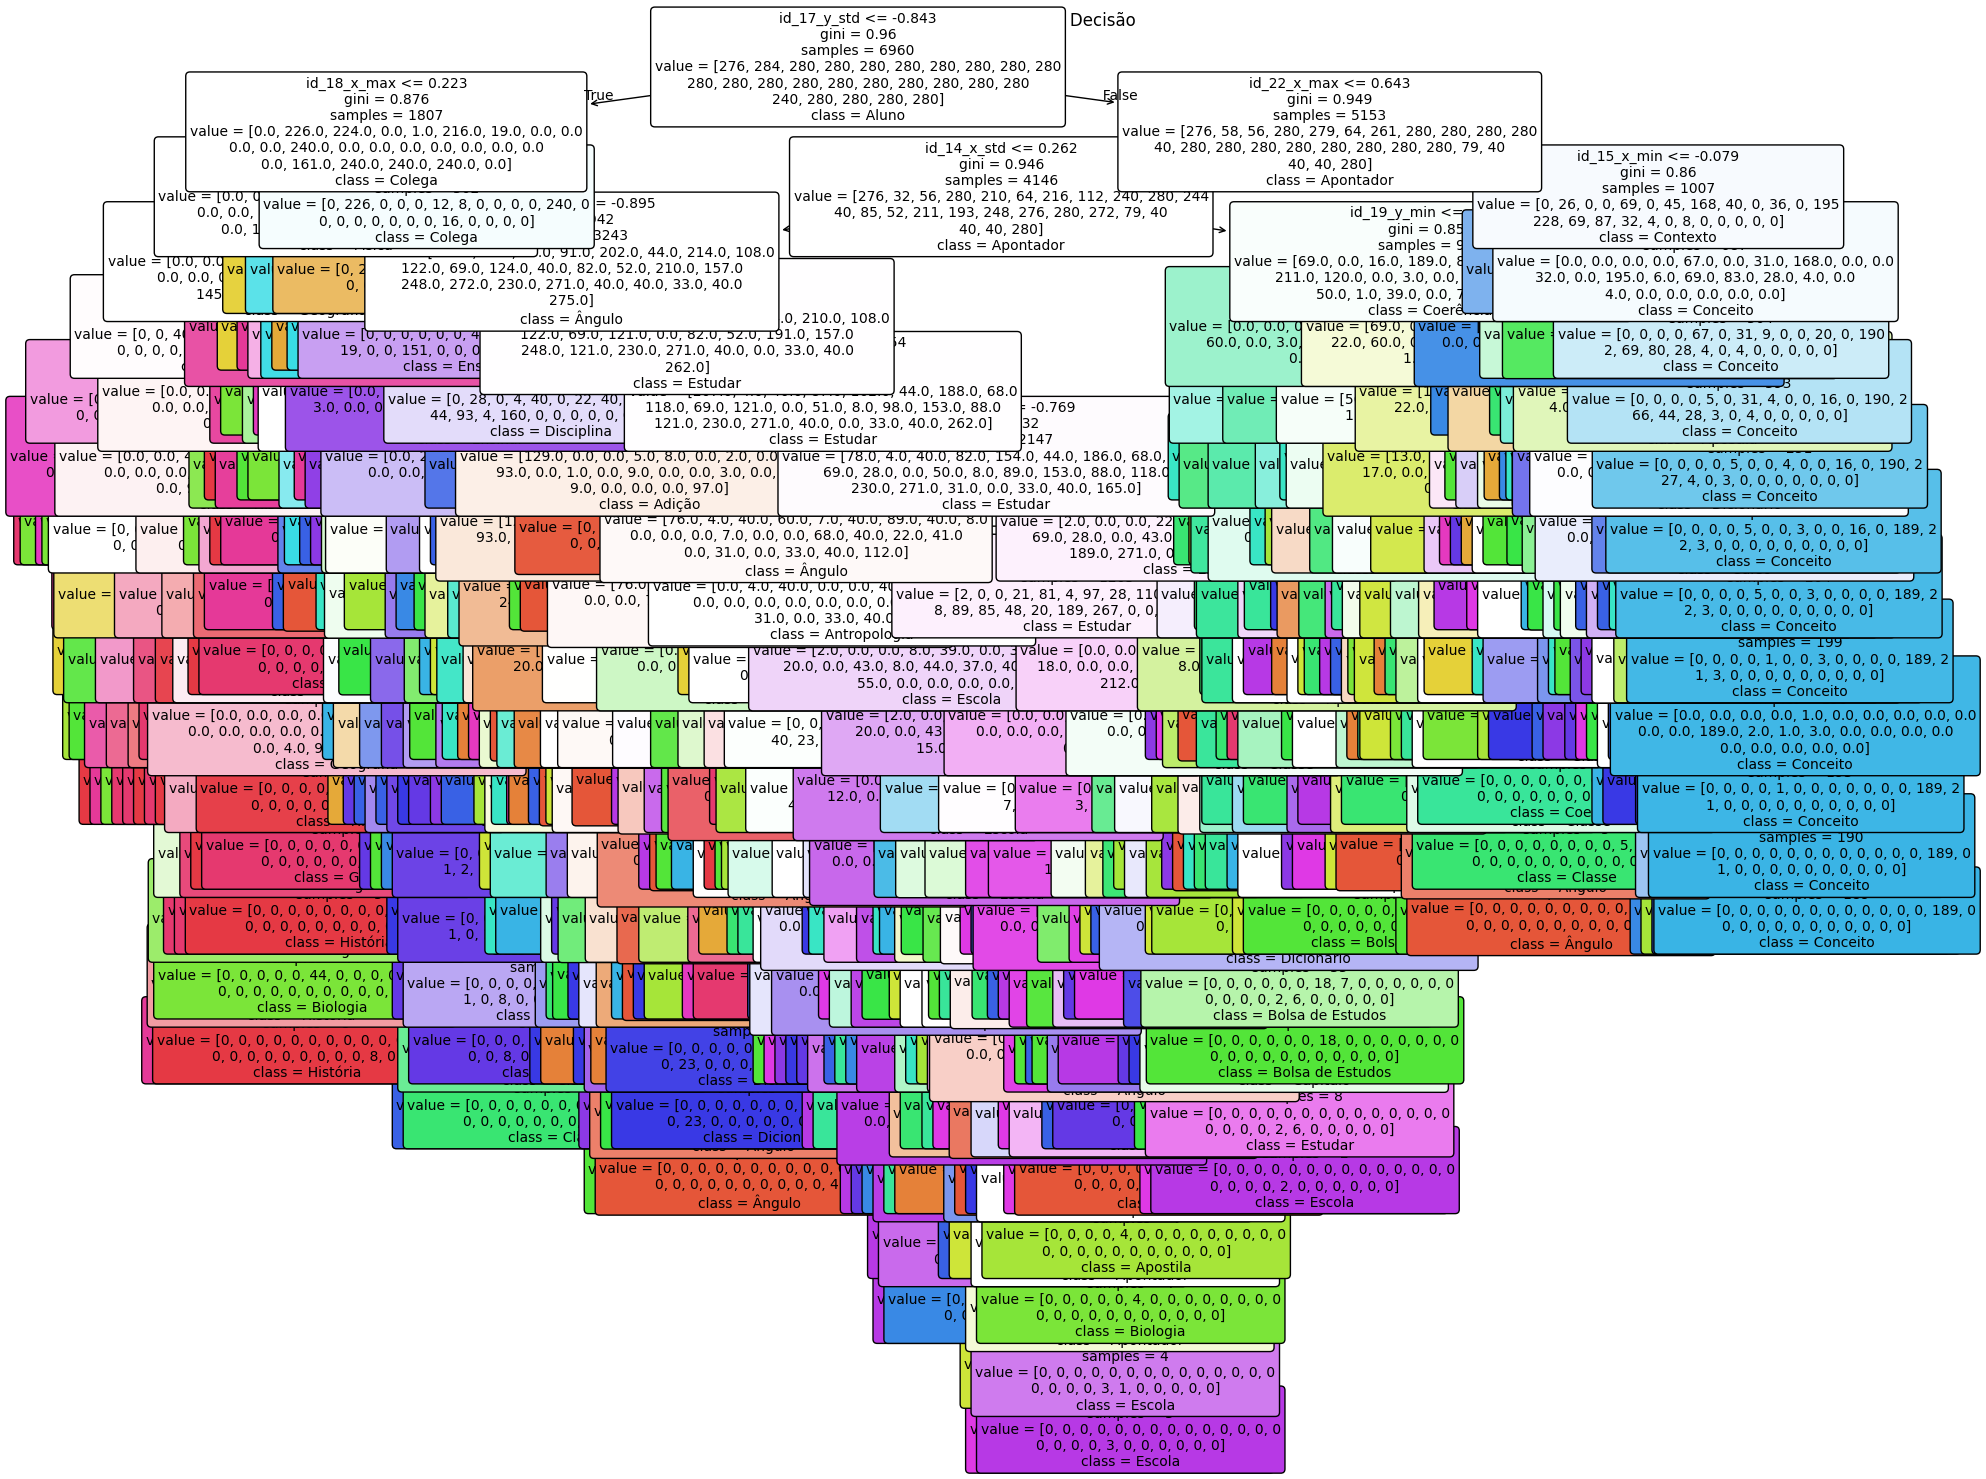

In [43]:

print("\n\n" + "="*50)
print("TREINANDO ÁRVORE DE DECISÃO")
print("="*50)

# Criando o modelo de árvore de decisão
dt_classifier = DecisionTreeClassifier(random_state=42)

# Criando o pipeline com o mesmo pré-processamento usado no MLP
dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', dt_classifier)
])

# Treinando o modelo
dt_pipeline.fit(X_train, y_train)

# Fazendo previsões
y_pred_dt = dt_pipeline.predict(X_test)

# Avaliando o modelo
print("\nResultados da Árvore de Decisão:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_dt, average='macro'):.4f}")
print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred_dt))

# Validação cruzada para F1-Score usando StratifiedGroupKFold
dt_f1_scores = cross_val_score(dt_pipeline, X_train, y_train, cv=cv, scoring='f1_macro', groups=groups_train)
print(f"\nF1-Score com validação cruzada estratificada por grupos (5-fold):")
print(f"Média: {dt_f1_scores.mean():.4f}, Desvio padrão: {dt_f1_scores.std():.4f}")
print(f"Scores individuais: {dt_f1_scores}")

# Matriz de confusão
plt.figure(figsize=(10, 8))
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.imshow(cm_dt, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)
plt.xlabel('Previsão')
plt.ylabel('Valor Real')

# Adicionando valores na matriz
thresh = cm_dt.max() / 2.
for i in range(cm_dt.shape[0]):
    for j in range(cm_dt.shape[1]):
        plt.text(j, i, format(cm_dt[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_dt[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Plotando a árvore de decisão
plt.figure(figsize=(20, 15))
classifier = dt_pipeline.named_steps['classifier']
plot_tree(classifier, 
          filled=True, 
          feature_names=X_train.columns,
          class_names=label_encoder.classes_,
          rounded=True,
          fontsize=10)
plt.title('Visualização da Árvore de Decisão')
plt.tight_layout()
plt.show()
